In [1]:
!pip install transformers -q
!pip install datasets -q
!pip install accelerate -U -q
!pip install evaluate -q
!pip install optuna -q

In [15]:
!pip install scikit-learn -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset
import pandas as pd
import torch
from collections import Counter

torch.manual_seed(1337)

In [2]:

filepath_tsv = "a3_train_final.tsv"
filepath_csv = "a3_train_final.csv"
test_filepath_tsv = "a3_test.tsv"
test_filepath_csv = "a3_test.csv"
model_name = "intfloat/e5-base-v2"

# load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


def preprocess_labels(labels: str):
    annotated_labels = labels.split("/") 
    counts = Counter(annotated_labels)

    # all labels appear the same amount of times, we assume that the last annotators is correct
    if len(set(counts.values())) == 1:
        return int(annotated_labels[-1])

    # else we return the most common in the group
    return int(counts.most_common(1)[0][0])

def preprocess_function(examples):
    # we use e5 so we need to add query prefix
    examples = ["query: " + example for example in examples["text"]]
    return tokenizer(examples, truncation=True)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:



# preprocess the train dataset
df = pd.read_csv(filepath_tsv, sep="\t", header=None)
# apply the label selection
df[0] = df[0].apply(preprocess_labels)
# remove rows labeled as -1
df = df.loc[df[0] != -1]

df.to_csv(filepath_csv, index=False)

# preprocess the test dataset
df = pd.read_csv(test_filepath_tsv, sep="\t", header=None)
df.to_csv(test_filepath_csv, index=False)
test_dataset = load_dataset("csv", data_files=test_filepath_csv)

#rename the columns for interpretability
test_dataset = test_dataset.rename_column("0", "label")
test_dataset = test_dataset.rename_column("1", "text")
test_dataset = test_dataset.map(preprocess_function, batched=True)["train"]

dataset = load_dataset("csv", data_files=filepath_csv)
dataset = dataset.rename_column("0", "label")
dataset = dataset.rename_column("1", "text")
dataset = dataset.map(preprocess_function, batched=True)["train"]
split_dataset = dataset.train_test_split(0.2, shuffle=True, seed=0)

train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]





In [4]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Computes f1 and accuracy scores for the model predictions
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy_score = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score = f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1_score, "accuracy": accuracy_score}

In [5]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="covid_classification",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    logging_strategy="steps",
    logging_steps=400,
    num_train_epochs=4,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

)

trainer.train()


Step,Training Loss,Validation Loss,F1,Accuracy
400,0.362700,0.278683,0.894483,0.894054
800,0.276300,0.256050,0.903958,0.902407
1200,0.256500,0.283237,0.901618,0.902407
1600,0.184100,0.271920,0.909306,0.907462
2000,0.173200,0.267339,0.910979,0.911419
2400,0.153000,0.298641,0.912670,0.911749
2800,0.102400,0.326358,0.910459,0.909770
3200,0.110400,0.323370,0.912642,0.911529
3600,0.094000,0.348532,0.911890,0.911309
4000,0.079300,0.348859,0.910169,0.910100


TrainOutput(global_step=4552, training_loss=0.16576070462882206, metrics={'train_runtime': 1072.9131, 'train_samples_per_second': 135.675, 'train_steps_per_second': 4.243, 'total_flos': 1.026155315899296e+16, 'train_loss': 0.16576070462882206, 'epoch': 4.0})

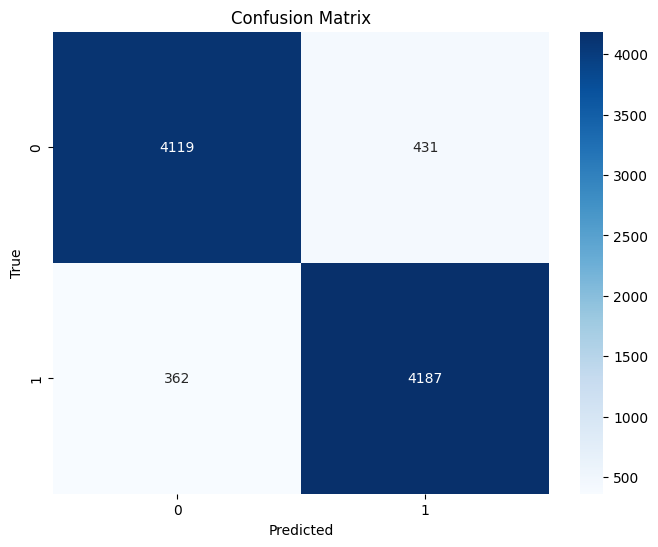

Metric                        Value
-----------------------  ----------
eval_loss                  0.353541
eval_f1                    0.913494
eval_accuracy              0.912848
eval_runtime              19.3313
eval_samples_per_second  470.687
eval_steps_per_second     14.743
epoch                      4
Metric                         Value
-----------------------  -----------
eval_loss                  0.0477545
eval_f1                    0.9895
eval_accuracy              0.989311
eval_runtime              75.0766
eval_samples_per_second  484.732
eval_steps_per_second     15.158
epoch                      4


In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# simple helper functions to print metrics and plot confusion matrices
def print_metrics(data):
    table = tabulate(data.items(), headers=["Metric", "Value"])
    print(table)

def plot_confusion_matrix(trainer, dataset):
    predictions = trainer.predict(dataset)
    
    predicted_labels = predictions.predictions.argmax(axis=1)
    true_labels = predictions.label_ids
    
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(trainer, eval_dataset)
print_metrics(trainer.evaluate(eval_dataset))
print_metrics(trainer.evaluate(train_dataset))


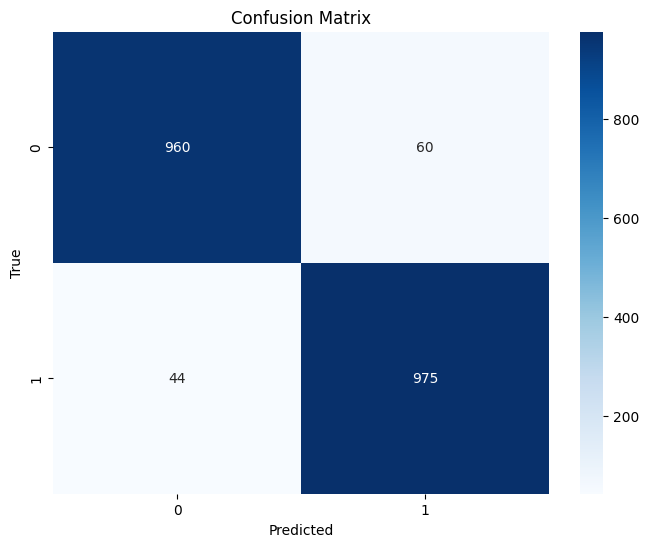

Metric                        Value
-----------------------  ----------
eval_loss                  0.181372
eval_f1                    0.949367
eval_accuracy              0.948995
eval_runtime               3.4407
eval_samples_per_second  592.611
eval_steps_per_second     18.601
epoch                      4


In [7]:
plot_confusion_matrix(trainer, test_dataset)
print_metrics(trainer.evaluate(test_dataset))

Metric       Value
--------  --------
f1        0.666618
accuracy  0.499945


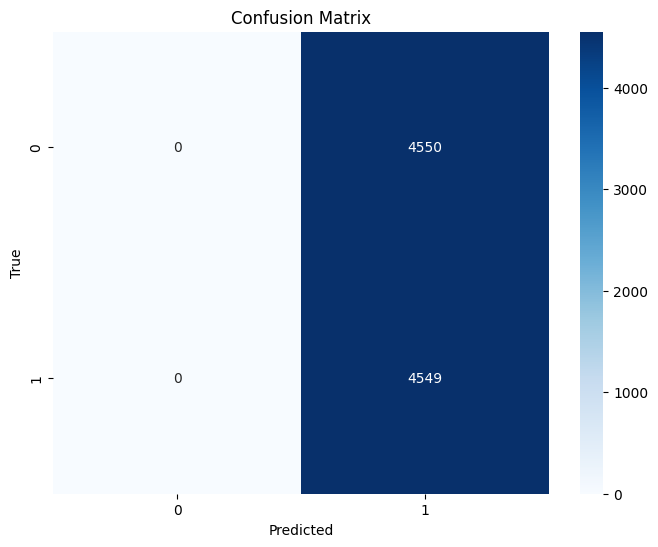

Metric       Value
--------  --------
f1        0.666449
accuracy  0.499755


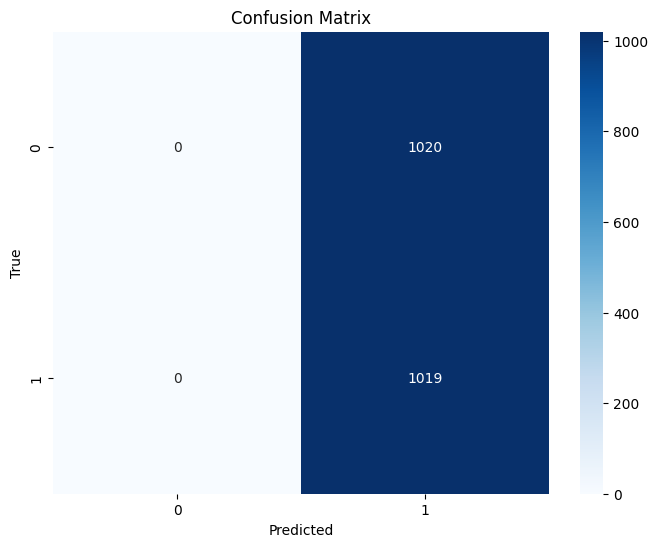

Metric       Value
--------  --------
f1        0.673664
accuracy  0.507914


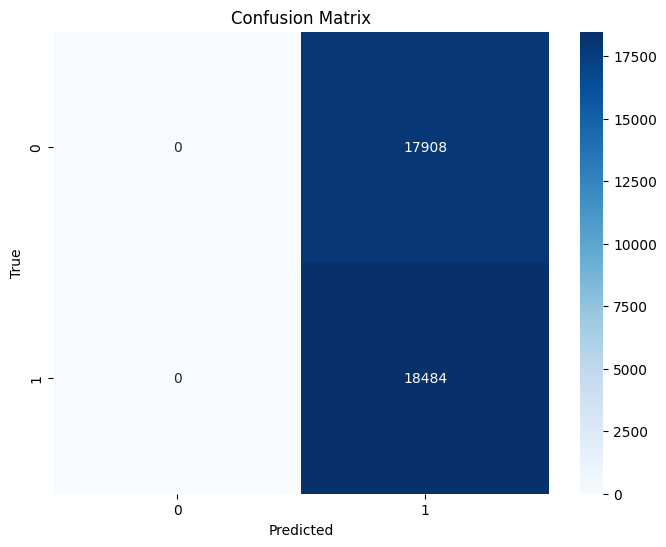

In [48]:
from sklearn.dummy import DummyClassifier

def dummy_confusion_matrix(X, y):
    predictions = dummy_clf.predict(X)
    f1_score = f1.compute(predictions=predictions, references=y)
    accuracy_score = accuracy.compute(predictions=predictions, references=y)
    print(tabulate({"f1": f1_score["f1"], "accuracy": accuracy_score["accuracy"]}.items(), headers=["Metric", "Value"]))
    
    conf_matrix = confusion_matrix(y, predictions)
        
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

X_train = train_dataset["text"]
y_train = train_dataset["label"]

X_val = eval_dataset["text"]
y_val = eval_dataset["label"]

X_test = test_dataset["text"]
y_test = test_dataset["label"]
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_confusion_matrix(X_val, y_val)
dummy_confusion_matrix(X_test, y_test)
dummy_confusion_matrix(X_train, y_train)



In [8]:

def get_wrong_predictions(trainer, dataset, num_samples = 10, shuffle: bool = False):
    """Helper function to get the wrong predictions of a model and the true labels"""
    predictions = trainer.predict(dataset)
    predicted_labels = predictions.predictions.argmax(axis=1)
    true_labels = predictions.label_ids


    # create a list of wrongly predicted indices
    wrong_prediction_indices = [i for i, b in enumerate(predicted_labels != true_labels) if b]

    wrong_predictions = dataset[wrong_prediction_indices]
    wrong_predictions = pd.DataFrame(wrong_predictions).drop(columns=["input_ids", "token_type_ids", "attention_mask", "label"])
    wrong_predictions["true_label"] = true_labels[wrong_prediction_indices]
    wrong_predictions["predicted_label"] = predicted_labels[wrong_prediction_indices]
    wrong_predictions = wrong_predictions[["text", "predicted_label", "true_label"]]
    if shuffle:
        wrong_predictions = wrong_predictions.sample(frac=1)
    return wrong_predictions[:num_samples]
    
    

In [9]:
wrong_predictions_df = get_wrong_predictions(trainer, test_dataset, num_samples=10000)

In [46]:
wrong_predictions_df

,text,predicted_label,true_label
0,Don't tell me what to do with my body - the sa...,0,1
1,It's safe because it wasn't rushed. I could ma...,1,0
2,Vaccines are saving lives meanwhile romania be...,1,0
3,We take other risks so taking this one shouldn...,1,0
4,1 death from a vaccine is too many.,1,0
...,...,...,...
99,that vaccines are preventing millions of death...,1,0
100,the vaccine is developed by a trusted company,0,1
101,“Anti-vaxers” are just more intelligent than t...,1,0
102,“Covid-19 is created by demon” Earth is turnon...,1,0


In [79]:
original_df = pd.read_csv(filepath_tsv, sep="\t", header=None)

# simple code to calculate the proportion of examples where all annotators agree on the same label
agree = 0
disagree = 0
test = 0
for labels in original_df[0]:
    annotated_labels = labels.split("/") 
    set_of_labels = set(annotated_labels)
    counts = Counter(annotated_labels)

    if len(set_of_labels) == 1:
        agree += 1
    else:
        disagree += 1


print("proportion of examples where all annotators agree on the same label: ", agree / len(original_df))
print("proportion of examples where annotators disagree on the same label: ", disagree / len(original_df))

proportion of examples where all annotators agree on the same label:  0.8437924422785013
proportion of examples where annotators disagree on the same label:  0.15620755772149877
